# Clothes Segmentation. Experiment 2

**Author:** Dmytro Lopushanskyy  
**Date:** 14 June 2022  

# Experiment Description

## New Batch size

The main problem of the previous notebook was a very small batch size. This was the cause of the metrics & logs not being able to achieve anything (they were just jumping up & down without making any progress). This has been corrected in this notebook by setting the batch size to 64.

It did not work at first because of GPU memory error, so I needed to decrease image size for that from 512 to 128.

## Increased Learning rate

I found learning rate to be too small since no progress could be made. This is why I decided to increase it ten times from 0.001 to 0.01.

## Improved Metrics calculation

Previuos notebook is likely to have a problem with metrics calculation. The input shape was (N_batches, Channels, W, H)
and the ground-truth labels were of shape (1, W, H). To fix this, I have used numpy argmax function that joined all channels into one by taking the most significant class index.


## All other changes

* Tried different data sizes, chose 25% of the whole dataset
* Increased epochs from 20 to 100
* Increased logging step to 500 to smooth the graphs


# Experiment Results

Achieved a steady decrease of the loss function and a stable increase of the three metrics used.  

## Test Metrics

'test_loss': 1.0623058080673218,  
'test_acc': 0.681684672832489,  
'test_jaccard': 0.3261496424674988,  
'test_f1': 0.23564200103282928  

# Experiment Notebook

In [1]:
class_grouping = { 
    0: 0, 1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 1, 10: 2, 
    11: 1, 12: 1, 13: 3, 14: 3, 15: 3, 16: 4, 17: 5, 18: 5, 19: 6, 
    20: 7, 21: 7, 22: 7, 23: 7, 24: 8, 25: 4, 26: 8, 27: 0, 28: 4, 29: 4, 
    30: 4, 31: 5, 32: 2, 33: 4, 34: 6, 35: 1, 36: 2, 37: 9, 38: 9, 39: 9, 
    40: 9, 41: 9, 42: 9, 43: 9, 44: 9, 45: 9
}

new_class_desc = {
    0: '(shirt, blouse, top, t-shirt, sweatshirt, sweater, cardigan, hood)',
    1: '(jacket, vest, coat, jumpsuit, cape, zipper)',
    2: '(pants, pocket, shorts, skirt, dress, applique)',
    3: '(glasses, hat, headband, head covering, hair accessory)',
    4: '(tie, scarf, collar, lapel, epaulette, neckline)',
    5: '(glove, sleeve, watch)',
    6: '(belt, buckle)',
    7: '(leg warmer, tights, stockings, sock, shoe)',
    8: '(bag, wallet, umbrella)',
    9: 'decorations'
}

## Config

In [2]:
config = {
    'dataset_root': './',
    'img_size': [128, 128],
    'train': {
        'img_path': './train'
    },
    'test': {
        'img_path': './test'
    },
    'model': {
        'lr': '1e-2',
        'num_classes': 11,  # reduced here from 49 to 10
        'num_layers': 5,
        'features_start': 64,
        'bilinear': False,
        'grad_batches': 1,
        'epochs': 100
    },
    'ignore_value': 10,
    'batch_size': 32,
    'data_size': -1  # take all data
}

## Imports

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import yaml
import random
import pickle
import numpy as np
import pandas as pd
import json
import cv2
import torch
import torch.nn.functional as F
import albumentations as albu
import torchvision.transforms as transforms
from tqdm import tqdm
from PIL import Image
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.loggers import WandbLogger
from torchmetrics.classification import Accuracy
from torchmetrics import F1Score, JaccardIndex  # IoU, F1
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import warnings

warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## EDA

In [4]:
json_file_path = f'{config["dataset_root"]}/label_descriptions.json'
train_csv_path = f'{config["dataset_root"]}/train.csv'

with open(json_file_path, 'r') as j:
    label_descriptions = json.loads(j.read())
    
train_df = pd.read_csv(train_csv_path)

In [5]:
train_df

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32
...,...,...,...,...,...
331208,fffe20b555b98c3c1f26c8dfff275cbc.jpg,2712731 8 2715725 23 2718719 39 2721713 55 272...,3000,2001,28
331209,ffffbf7014a9e408bfbb81a75bc70638.jpg,71179 1 71678 3 72178 4 72678 4 73178 5 73679 ...,500,375,33
331210,ffffbf7014a9e408bfbb81a75bc70638.jpg,116648 5 117148 16 117648 22 118148 26 118647 ...,500,375,31
331211,ffffbf7014a9e408bfbb81a75bc70638.jpg,67711 1 68210 1 68709 2 69204 2 69208 3 69705 ...,500,375,31


## Dataset Initialization

In [6]:
class FashionDataset(Dataset):
    ignore_value = config['ignore_value']
    
    def __init__(self, config, dataset_type='train', transform=None):
        self.type = dataset_type
        self.root_dir = config['dataset_root']
        self.imgs_path = os.path.join(self.root_dir, config['train']['img_path'])
        self.img_size = config['img_size']
        self.transform = transform
        
        self.img_files = os.listdir(self.imgs_path)
        data_size = config['data_size']
        if data_size > 0:
            self.img_files = os.listdir(self.imgs_path)[:data_size]
        
        
    def __len__(self):
        return len(self.img_files)
    
    def make_mask_img(self, segment_df):
        seg_width = segment_df['Width'].iat[0]
        seg_height = segment_df['Height'].iat[0]
        seg_img = np.full(seg_width*seg_height, self.ignore_value, dtype=np.int32)
        for encoded_pixels, class_id in zip(segment_df['EncodedPixels'].values, segment_df['ClassId'].values):
            pixel_list = list(map(int, encoded_pixels.split(" ")))
            for i in range(0, len(pixel_list), 2):
                start_index = pixel_list[i] - 1
                index_len = pixel_list[i+1] - 1
                cls_id = int(class_id.split("_")[0])
                new_cls_id = class_grouping[cls_id]
                seg_img[start_index:start_index+index_len] = new_cls_id
        seg_img = seg_img.reshape((seg_height, seg_width), order='F')
        seg_img = cv2.resize(seg_img, self.img_size, interpolation=cv2.INTER_NEAREST)
        return seg_img
    
    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        
        img = cv2.imread(f'{self.imgs_path}/{img_name}')
        img = cv2.resize(img, self.img_size, interpolation=cv2.INTER_NEAREST)
        segment_df = (train_df[train_df['ImageId'] == img_name]).reset_index(drop=True)
        if segment_df['ImageId'].nunique() != 1:
            raise Exception('Index Range Error')
            
        mask = self.make_mask_img(segment_df)
        img = img.transpose((2, 0, 1))  # HWC -> CHW
        
        if self.transform:
            transformed = self.transform(image=img, mask=mask)
            img = transformed['image']
            mask = transformed['mask']

        return np.float32(img / 255), np.int32(mask)
    
def get_categories(mask):
    """ Get category description from the mask """
    categories = np.unique(mask)
    categories = np.delete(categories, np.where(categories == config['ignore_value']))  # filter
    categories = [f"{int(idx)} - {new_class_desc[idx]}" for idx in categories]
    return categories

In [7]:
dataset = FashionDataset(config)

# UNet

UNet code below taken from Yura's lab

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        return self.net(x)
    
class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_ch, out_ch)
        )
        
    def forward(self, x):
        return self.net(x)
    
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super().__init__()
        self.unsample = None
        if bilinear:
            self.unsample = nn.Unsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.unsample = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
            
        self.conv = DoubleConv(in_ch, out_ch)
        
    def forward(self, x1, x2):
        x1 = self.unsample(x1)
        
        # Pad x1 to the size of x2
        diff_h = x2.shape[2] - x1.shape[2]
        diff_w = x2.shape[3] - x1.shape[3]
        
        x1 = F.pad(x1, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])
        
        # Concatanate alond the channel axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, num_classes=19, num_layers=5, features_start=64, bilinear=False):
        super().__init__()
        self.num_layers = num_layers
        
        layers = [DoubleConv(3, features_start)]
        
        feats = features_start
        for _ in range(num_layers-1):
            layers.append(Down(feats, feats*2))
            feats *= 2
            
        for _ in range(num_layers-1):
            layers.append(Up(feats, feats//2))
            feats //= 2
            
        layers.append(nn.Conv2d(feats, num_classes, kernel_size=1))
        
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        xi = [self.layers[0](x)]
        for layer in self.layers[1:self.num_layers]:
            xi.append(layer(xi[-1]))
        for i, layer in enumerate(self.layers[self.num_layers:-1]):
            xi[-1] = layer(xi[-1], xi[-2-i])
        return self.layers[-1](xi[-1])

## Own Model

In [10]:
class SegModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.lr = float(config['model']['lr'])
        self.model = UNet(num_classes=self.config['model']['num_classes'], 
                          num_layers=self.config['model']['num_layers'],
                          features_start=self.config['model']['features_start'],
                          bilinear=self.config['model']['bilinear'])
        self.accuracy = Accuracy(num_classes=self.config['model']['num_classes'], 
                                 ignore_index=config['ignore_value'],
                                 mdmc_average='global')
        self.jaccard = JaccardIndex(num_classes=self.config['model']['num_classes'],
                                    ignore_index=config['ignore_value'],
                                    mdmc_average='global')
        self.f1 = F1Score(num_classes=self.config['model']['num_classes'], 
                          ignore_index=config['ignore_value'],
                          mdmc_average='global')
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        
        out = self(img)
        joined_mask = out.argmax(axis=1)
        
        loss_val = F.cross_entropy(out, mask, ignore_index=FashionDataset.ignore_value)
        
        acc_res = self.accuracy(joined_mask, mask)
        jac_res = self.jaccard(joined_mask, mask)
        f1_res = self.f1(joined_mask, mask)
        
        self.log('train_loss', loss_val)
        self.log("train_acc", acc_res)
        self.log("train_jaccard", jac_res)
        self.log("train_f1", f1_res)
        
        return loss_val
    
    def test_step(self, batch, batch_idx):
        img, mask = batch
        img = img.float()
        mask = mask.long()
        
        out = self(img)
        joined_mask = out.argmax(axis=1)
        
        loss_val = F.cross_entropy(out, mask, ignore_index=FashionDataset.ignore_value)
        
        acc_res = self.accuracy(joined_mask, mask)
        jac_res = self.jaccard(joined_mask, mask)
        f1_res = self.f1(joined_mask, mask)
        
        self.log('test_loss', loss_val)
        self.log("test_acc", acc_res)
        self.log("test_jaccard", jac_res)
        self.log("test_f1", f1_res)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=10)
        return [opt], [sch]

## Lightning Data Module

In [11]:
class FasionDataModel(pl.LightningDataModule):
    def __init__(self, config):
        self.data_config = config
        self.batch_size = config['batch_size']
        self.prepare_data_per_node = True
        self._log_hyperparams = True
        
        self.transform = albu.Compose([
            albu.ShiftScaleRotate(shift_limit=0.0, scale_limit=0.1, rotate_limit=10, p=0.4),
            albu.OneOf(
                [
                    albu.RandomBrightnessContrast(),
                    albu.MedianBlur(),
                ], 
                p=0.5
            )
        ])
        
        full_dataset = FashionDataset(config, transform=self.transform)
        train_size = int(len(full_dataset) * 0.8)
        val_size = len(full_dataset) - train_size
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=64)
    
    def test_dataloader(self):
        # evaluate on validation dataset
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=64)

In [12]:
model = SegModel(config)
data_module = FasionDataModel(config)

In [13]:
wandb_logger = WandbLogger()

wandb: Currently logged in as: dlopushanskyy. Use `wandb login --relogin` to force relogin


In [14]:
logger = TensorBoardLogger("tb_logs", name="fashion_model")
trainer = pl.Trainer(
    gpus=[0],
    accelerator="auto",
    logger=wandb_logger,
    max_epochs=config['model']['epochs'],
    accumulate_grad_batches=config['model']['grad_batches'],
    limit_train_batches=0.25,
    limit_test_batches=0.25,
    log_every_n_steps=500
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [15]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

  | Name     | Type         | Params
------------------------------------------
0 | model    | UNet         | 31.0 M
1 | accuracy | Accuracy     | 0     
2 | jaccard  | JaccardIndex | 0     
3 | f1       | F1Score      | 0     
------------------------------------------
31.0 M    Trainable params
0         Non-trainable params
31.0 M    Total params
124.177   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [16]:
trainer.test(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.681684672832489
         test_f1            0.23564200103282928
      test_jaccard          0.3261496424674988
        test_loss           1.0623058080673218
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0623058080673218,
  'test_acc': 0.681684672832489,
  'test_jaccard': 0.3261496424674988,
  'test_f1': 0.23564200103282928}]

## Save Model

In [17]:
pickle.dump(model, open('output/fashion-model-exp-2.pkl', 'wb'))

# WandB Visualization

### Finally, we can see a clear downhill trend of the loss values and a steady increase of our metrics!

![img](https://user-images.githubusercontent.com/25267308/173694757-bc628a27-2aa0-4746-8854-79c94fb18996.png)


![img](https://user-images.githubusercontent.com/25267308/173694884-244efa20-4327-47f8-b370-8d68ba3cd87c.png)

# See Results

Get random images from the test dataset to see the performance

In [18]:
N_IMAGES = 2

In [19]:
model.eval()
test_loader = data_module.train_dataloader()
img, mask_test = next(iter(test_loader))
img = img.float()

In [20]:
y = model.forward(img)

In [21]:
joined_mask = y.argmax(axis=1)[:N_IMAGES]

In [22]:
img = np.array(img[:N_IMAGES])
mask_test = mask_test[:N_IMAGES]

Train Example 0

True Categories:
0 - (shirt, blouse, top, t-shirt, sweatshirt, sweater, cardigan, hood)
2 - (pants, pocket, shorts, skirt, dress, applique)
6 - (belt, buckle)

Predicted Categories:
0 - (shirt, blouse, top, t-shirt, sweatshirt, sweater, cardigan, hood)
1 - (jacket, vest, coat, jumpsuit, cape, zipper)
2 - (pants, pocket, shorts, skirt, dress, applique)
3 - (glasses, hat, headband, head covering, hair accessory)
4 - (tie, scarf, collar, lapel, epaulette, neckline)
5 - (glove, sleeve, watch)

Train Example 1

True Categories:
0 - (shirt, blouse, top, t-shirt, sweatshirt, sweater, cardigan, hood)
2 - (pants, pocket, shorts, skirt, dress, applique)
6 - (belt, buckle)

Predicted Categories:
0 - (shirt, blouse, top, t-shirt, sweatshirt, sweater, cardigan, hood)
1 - (jacket, vest, coat, jumpsuit, cape, zipper)
2 - (pants, pocket, shorts, skirt, dress, applique)
3 - (glasses, hat, headband, head covering, hair accessory)
4 - (tie, scarf, collar, lapel, epaulette, neckline)
5 - 

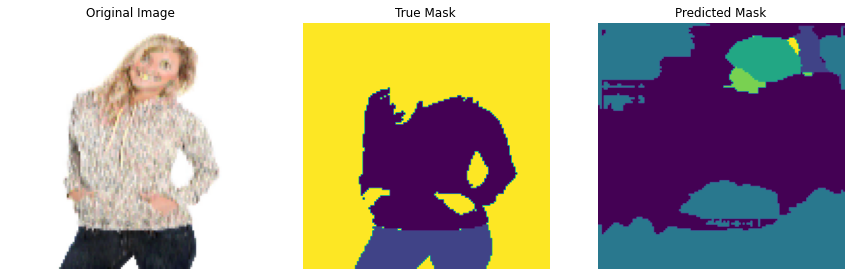

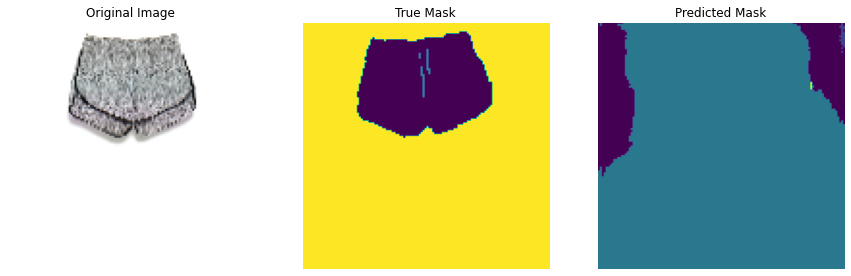

In [23]:
for i in range(N_IMAGES):
    plt.rcParams['figure.figsize'] = [15, 10]
    fig = plt.figure()

    rows, cols = 1, 3

    fig.add_subplot(rows, cols, 1)
    plt.imshow(cv2.cvtColor(img[i].transpose((1, 2, 0)), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')

    fig.add_subplot(rows, cols, 2)
    plt.imshow(mask_test[i])
    plt.axis('off')
    plt.title('True Mask')

    fig.add_subplot(rows, cols, 3)
    plt.imshow(joined_mask[i])
    plt.axis('off')
    plt.title('Predicted Mask')

    plt.savefig(f'output/output_{i}.png')

    print(f'Train Example {i}\n')
    new_line_ch = '\n'
    print(f'True Categories:\n{new_line_ch.join(get_categories(mask_test))}\n')
    print(f'Predicted Categories:\n{new_line_ch.join(get_categories(joined_mask))}\n')

### Unfortunately, the predicted masks are still far away from the true masks.

Please continue to Experiment 3 for better results.